In [5]:
import sys
import os
import json

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

notebook_path = os.getcwd() 
project_root = os.path.dirname(notebook_path)  # get the project root directory
sys.path.append(project_root)

from generator.nl_data_generator import *
from generator.utils import *
from generator.constraint import *
from models.nl_functions import *
from heuristic.nl_heuristic import *

%load_ext autoreload
%autoreload 2
print("✅ Modules imported successfully.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Modules imported successfully.


In [6]:
## 2. Unconstrained Assortment Optimization
# In this section, we solve the assortment optimization problem without any additional constraints.

### Load Data
# - We provide two json files in the hard_data folder based on different vi0 distributions
# - The number of nests $m \in \{5, 10, 15\}$
# - The number of products per nest $n \in \{25, 50, 75\}$
# - The vi0 distributions include:
#   - **uniform01**: vi0 ~ Uniform(0, 1) - Low outside-nest utility
#   - **uniform34**: vi0 ~ Uniform(3, 4) - High outside-nest utility

In [7]:
hard_instance_dir = project_root + "/hard_data/"
vi0_method = '01'  # Options: 'uniform01', 'uniform34'
input_json_path = hard_instance_dir + "nl_unconstrained_" + vi0_method + "_data.json"
instances = load_NL_instances(input_json_path)
print(f"✅ Loaded {len(instances)} instances")

✅ Loaded 139 instances


INSTANCE OVERVIEW
Number of nests (m): 5
Number of products per nest (n): 25
Total number of products: 125
Random seed: 46
Capacity rate: 1
Maximum revenue (optimal): 6.2455
Gap: 0.0862%

DATA COMPONENTS - DIMENSIONS

1. Utility Matrix (v)
   Shape: (5, 25)
   Description: Rows = nests, Columns = products within each nest
   Each entry v[i,j] represents the utility of product j in nest i
   Range: [0.0811, 11.5391]

2. Product Prices (price)
   Shape: (5, 25)
   Range: [0.0004, 11.2488]
   Description: Revenue generated when a product is purchased

3. Dissimilarity Parameter (gamma)
   Shape: (5,)
   Range: [2.0772, 2.9340]
   Description: Captures correlation of products within each nest
   Higher gamma means products in the nest are more similar

4. No-Purchase Option Utility (v0)
   Value: 10.0000
   Description: Global utility of not purchasing any product

5. Within-Nest No-Purchase Utility (vi0)
   Shape: (5,)
   Range: [0.0772, 0.9340]
   Description: Utility of not purchasing w

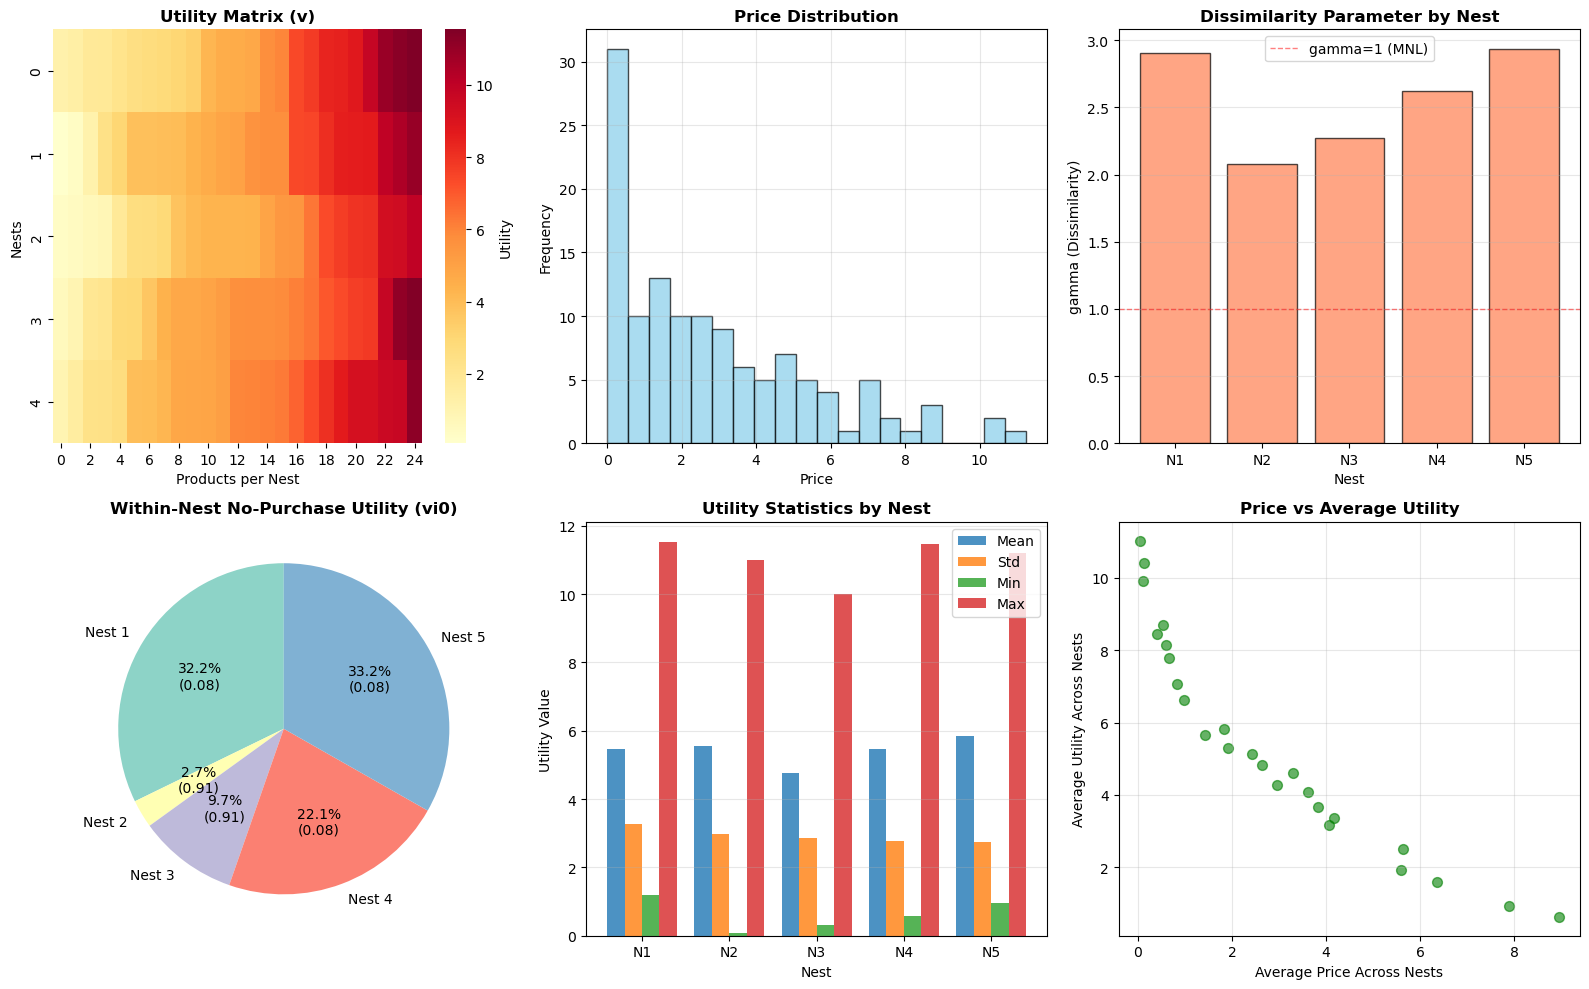


SUMMARY STATISTICS

Utility Matrix Statistics:
  Mean: 5.4245
  Std: 2.9468
  Min: 0.0811
  Max: 11.5391

Price Statistics:
  Mean: 2.8361
  Std: 2.6231
  Min: 0.0004
  Max: 11.2488

Dissimilarity Parameter Statistics:
  Mean: 2.5623
  Std: 0.3402
  Min: 2.0772
  Max: 2.9340

Within-Nest No-Purchase Utility Statistics:
  Mean: 0.5623
  Std: 0.3402
  Min: 0.0772
  Max: 0.9340


In [8]:
# =============================================================================
# PART 1: LOAD AND EXPLORE A SINGLE INSTANCE
# =============================================================================

# Select one instance for detailed demonstration
data = instances[0]  # Using the first instance as an example

# -----------------------------------------------------------------------------
# Display Basic Instance Information
# -----------------------------------------------------------------------------
print("=" * 80)
print("INSTANCE OVERVIEW")
print("=" * 80)
print(f"Number of nests (m): {data.m}")
print(f"Number of products per nest (n): {data.n}")
print(f"Total number of products: {data.m * data.n}")
print(f"Random seed: {data.seed}")
print(f"Capacity rate: {data.cap_rate}")
print(f"Maximum revenue (optimal): {data.max_rev:.4f}")
print(f"Gap: {data.gap:.4f}%")

# -----------------------------------------------------------------------------
# Display Data Structure and Dimensions
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("DATA COMPONENTS - DIMENSIONS")
print("=" * 80)

# Flatten arrays to ensure proper format
price_flat = data.price.flatten()
v_flat = data.v.flatten()
vi0_1d = data.vi0.flatten() if isinstance(data.vi0, np.ndarray) and len(data.vi0.shape) > 0 else np.array([data.vi0])
gamma_1d = data.gamma.flatten() if len(data.gamma.shape) > 1 else data.gamma

# 1. Utility Matrix (v)
print(f"\n1. Utility Matrix (v)")
print(f"   Shape: {data.v.shape}")
print(f"   Description: Rows = nests, Columns = products within each nest")
print(f"   Each entry v[i,j] represents the utility of product j in nest i")
print(f"   Range: [{v_flat.min():.4f}, {v_flat.max():.4f}]")

# 2. Product Prices
print(f"\n2. Product Prices (price)")
print(f"   Shape: {data.price.shape}")
print(f"   Range: [{price_flat.min():.4f}, {price_flat.max():.4f}]")
print(f"   Description: Revenue generated when a product is purchased")

# 3. Dissimilarity Parameter
print(f"\n3. Dissimilarity Parameter (gamma)")
print(f"   Shape: {data.gamma.shape}")
print(f"   Range: [{gamma_1d.min():.4f}, {gamma_1d.max():.4f}]")
print(f"   Description: Captures correlation of products within each nest")
print(f"   Higher gamma means products in the nest are more similar")

# 4. No-Purchase Option Utility (Global)
print(f"\n4. No-Purchase Option Utility (v0)")
print(f"   Value: {data.v0:.4f}")
print(f"   Description: Global utility of not purchasing any product")

# 5. Within-Nest No-Purchase Option
print(f"\n5. Within-Nest No-Purchase Utility (vi0)")
if isinstance(data.vi0, np.ndarray) and data.vi0.size > 1:
    print(f"   Shape: {data.vi0.shape}")
    print(f"   Range: [{vi0_1d.min():.4f}, {vi0_1d.max():.4f}]")
    print(f"   Description: Utility of not purchasing within each nest")
else:
    print(f"   Value: {data.vi0:.4f}")
    print(f"   Description: Uniform utility across all nests (full capture scenario)")

# -----------------------------------------------------------------------------
# Visualize the Data
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("DATA VISUALIZATION")
print("=" * 80)

# Create a comprehensive figure with 6 subplots
fig = plt.figure(figsize=(16, 10))

# Subplot 1: Utility Matrix Heatmap
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(data.v, cmap='YlOrRd', cbar_kws={'label': 'Utility'}, ax=ax1)
ax1.set_title('Utility Matrix (v)', fontweight='bold')
ax1.set_xlabel('Products per Nest')
ax1.set_ylabel('Nests')

# Subplot 2: Price Distribution
ax2 = plt.subplot(2, 3, 2)
ax2.hist(price_flat, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
ax2.set_title('Price Distribution', fontweight='bold')
ax2.set_xlabel('Price')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

# Subplot 3: Dissimilarity Parameters by Nest
ax3 = plt.subplot(2, 3, 3)
ax3.bar(range(data.m), gamma_1d, edgecolor='black', alpha=0.7, color='coral')
ax3.set_title('Dissimilarity Parameter by Nest', fontweight='bold')
ax3.set_xlabel('Nest')
ax3.set_ylabel('gamma (Dissimilarity)')
ax3.set_xticks(range(data.m))
ax3.set_xticklabels([f'N{i+1}' for i in range(data.m)])
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=1, color='r', linestyle='--', alpha=0.5, linewidth=1, label='gamma=1 (MNL)')
ax3.legend()

# Subplot 4: Within-Nest No-Purchase Utility
ax4 = plt.subplot(2, 3, 4)
if isinstance(data.vi0, np.ndarray) and data.vi0.size > 1:
    colors = plt.cm.Set3(range(data.m))
    ax4.pie(vi0_1d, labels=[f'Nest {i+1}' for i in range(data.m)], 
            autopct=lambda pct: f'{pct:.1f}%\n({vi0_1d[int(pct/100.*len(vi0_1d))]:.2f})', 
            colors=colors, startangle=90)
    ax4.set_title('Within-Nest No-Purchase Utility (vi0)', fontweight='bold')
else:
    ax4.text(0.5, 0.5, f'vi0 = {data.vi0:.4f}\n(Full Capture)', 
             ha='center', va='center', fontsize=14, transform=ax4.transAxes)
    ax4.set_title('Within-Nest No-Purchase Utility', fontweight='bold')
    ax4.axis('off')

# Subplot 5: Utility Statistics by Nest
ax5 = plt.subplot(2, 3, 5)
utility_stats = pd.DataFrame({
    'Mean': data.v.mean(axis=1),
    'Std': data.v.std(axis=1),
    'Min': data.v.min(axis=1),
    'Max': data.v.max(axis=1)
})
x = np.arange(data.m)
width = 0.2
ax5.bar(x - width*1.5, utility_stats['Mean'], width, label='Mean', alpha=0.8)
ax5.bar(x - width*0.5, utility_stats['Std'], width, label='Std', alpha=0.8)
ax5.bar(x + width*0.5, utility_stats['Min'], width, label='Min', alpha=0.8)
ax5.bar(x + width*1.5, utility_stats['Max'], width, label='Max', alpha=0.8)
ax5.set_title('Utility Statistics by Nest', fontweight='bold')
ax5.set_xlabel('Nest')
ax5.set_ylabel('Utility Value')
ax5.set_xticks(x)
ax5.set_xticklabels([f'N{i+1}' for i in range(data.m)])
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Subplot 6: Price vs Average Utility
ax6 = plt.subplot(2, 3, 6)
avg_utility = data.v.mean(axis=0)
price_per_product = data.price.mean(axis=0)
ax6.scatter(price_per_product, avg_utility, alpha=0.6, s=50, color='green')
ax6.set_title('Price vs Average Utility', fontweight='bold')
ax6.set_xlabel('Average Price Across Nests')
ax6.set_ylabel('Average Utility Across Nests')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# Summary Statistics
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

print(f"\nUtility Matrix Statistics:")
print(f"  Mean: {data.v.mean():.4f}")
print(f"  Std: {data.v.std():.4f}")
print(f"  Min: {data.v.min():.4f}")
print(f"  Max: {data.v.max():.4f}")

print(f"\nPrice Statistics:")
print(f"  Mean: {price_flat.mean():.4f}")
print(f"  Std: {price_flat.std():.4f}")
print(f"  Min: {price_flat.min():.4f}")
print(f"  Max: {price_flat.max():.4f}")

print(f"\nDissimilarity Parameter Statistics:")
print(f"  Mean: {gamma_1d.mean():.4f}")
print(f"  Std: {gamma_1d.std():.4f}")
print(f"  Min: {gamma_1d.min():.4f}")
print(f"  Max: {gamma_1d.max():.4f}")

if isinstance(data.vi0, np.ndarray) and data.vi0.size > 1:
    print(f"\nWithin-Nest No-Purchase Utility Statistics:")
    print(f"  Mean: {vi0_1d.mean():.4f}")
    print(f"  Std: {vi0_1d.std():.4f}")
    print(f"  Min: {vi0_1d.min():.4f}")
    print(f"  Max: {vi0_1d.max():.4f}")

In [9]:
# =============================================================================
# PART 2: RUN ALGORITHM ON ALL INSTANCES
# =============================================================================

# Initialize data paths and result storage
hard_instance_dir = project_root + "/hard_data/"
vi0_method_list = ['01', '34']  # Two vi0 distribution methods to test
results = []

# Loop through each vi0 method
for vi0_method in vi0_method_list:
    # Load instances for the current vi0 method
    input_json_path = hard_instance_dir + "nl_unconstrained_" + vi0_method + "_data.json"
    instances = load_NL_instances(input_json_path)
    
    print(f"\nProcessing {vi0_method}...")
    
    # Process each instance
    for idx, data in enumerate(instances):
        # Get the revenue function for this instance
        revenue_fn = get_revenue_function_nl(data)
        
        # Run the revenue-ordered heuristic algorithm for NL
        # This algorithm finds the optimal assortment by selecting
        # the k_i highest-revenue products in each nest i
        assortment = revenue_order_nl(data.m, data.n, data.v, data.price, 
                                      data.v0, data.vi0, data.gamma)
        
        # Calculate the revenue achieved by the heuristic
        revenue = revenue_fn(assortment)[0]
        
        # Get the optimal revenue (from exact solution)
        opt_rev = data.max_rev
        
        # Calculate the optimality gap (in percentage)
        gap_method = (opt_rev - revenue) / opt_rev * 100
        
        # Store results for this instance
        result_dict = {
            'm': data.m,                    # Number of nests
            'n': data.n,                    # Number of products per nest
            'vi0_method': vi0_method,       # vi0 distribution method
            'cap_rate': data.cap_rate,      # Capacity rate
            'seed': data.seed,              # Random seed for reproducibility
            'max_rev': opt_rev,             # Optimal revenue
            'gap_method': gap_method        # Optimality gap (%)
        }
        
        results.append(result_dict)

print(f"\n✅ Completed testing on {len(results)} instances.")


Processing 01...

Processing 34...

✅ Completed testing on 282 instances.


In [10]:
# =============================================================================
# PART 3: ANALYZE AND VISUALIZE RESULTS
# =============================================================================

# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(results)

# Create a combined column for (m, n) pairs for easier grouping
df_results['m_n'] = df_results['m'].astype(str) + '_' + df_results['n'].astype(str)

# Display basic statistics
print("\n" + "=" * 80)
print("RESULTS OVERVIEW")
print("=" * 80)
print(f"Total instances tested: {len(df_results)}")
print(f"vi0 methods: {df_results['vi0_method'].unique().tolist()}")
print(f"(m, n) combinations: {sorted(df_results['m_n'].unique().tolist())}")
print(f"\nOverall gap statistics:")
print(df_results['gap_method'].describe().round(4))


RESULTS OVERVIEW
Total instances tested: 282
vi0 methods: ['01', '34']
(m, n) combinations: ['10_25', '10_50', '20_25', '20_50', '5_25', '5_50']

Overall gap statistics:
count    282.0000
mean       9.7003
std       16.3690
min       -0.0000
25%        0.1884
50%        1.1197
75%       10.6875
max       69.3915
Name: gap_method, dtype: float64


In [11]:
# =============================================================================
# PART 4: SAVE DETAILED STATISTICS TO EXCEL
# =============================================================================

# Create output directory if it doesn't exist
output_dir = project_root + "/results/"
os.makedirs(output_dir, exist_ok=True)

# Save comprehensive statistics to Excel file
with pd.ExcelWriter(output_dir + 'nl_summary_statistics.xlsx', engine='openpyxl') as writer:
    # Sheet 1: All raw results
    df_results.to_excel(writer, sheet_name='All Results', index=False)
    
    # Create separate sheets for each vi0 method
    for vi0_method in df_results['vi0_method'].unique():
        df_vi0 = df_results[df_results['vi0_method'] == vi0_method]
        
        # Sheet: Mean gap by (m, n)
        pivot_mean = df_vi0.pivot_table(
            values='gap_method', 
            index='m',          # Rows: number of nests
            columns='n',        # Columns: number of products per nest
            aggfunc='mean'
        )
        pivot_mean.to_excel(writer, sheet_name=f'{vi0_method}_Mean')
        
        # Sheet: Standard deviation of gap by (m, n)
        pivot_std = df_vi0.pivot_table(
            values='gap_method', 
            index='m', 
            columns='n', 
            aggfunc='std'
        )
        pivot_std.to_excel(writer, sheet_name=f'{vi0_method}_Std')
        
        # Sheet: Detailed statistics for each (m, n) combination
        summary_by_mn = df_vi0.groupby('m_n')['gap_method'].describe()
        summary_by_mn.to_excel(writer, sheet_name=f'{vi0_method}_Details')
    
    # Sheet: Side-by-side comparison of both vi0 methods
    pivot_comparison = df_results.pivot_table(
        values='gap_method',
        index=['m', 'n'],
        columns='vi0_method',
        aggfunc='mean'
    )
    pivot_comparison.to_excel(writer, sheet_name='Comparison')

print(f"✅ Summary statistics saved to {output_dir}nl_summary_statistics.xlsx")

✅ Summary statistics saved to /Users/miracleletter/Library/Mobile Documents/com~apple~CloudDocs/code/Assortment Benchmark/results/nl_summary_statistics.xlsx


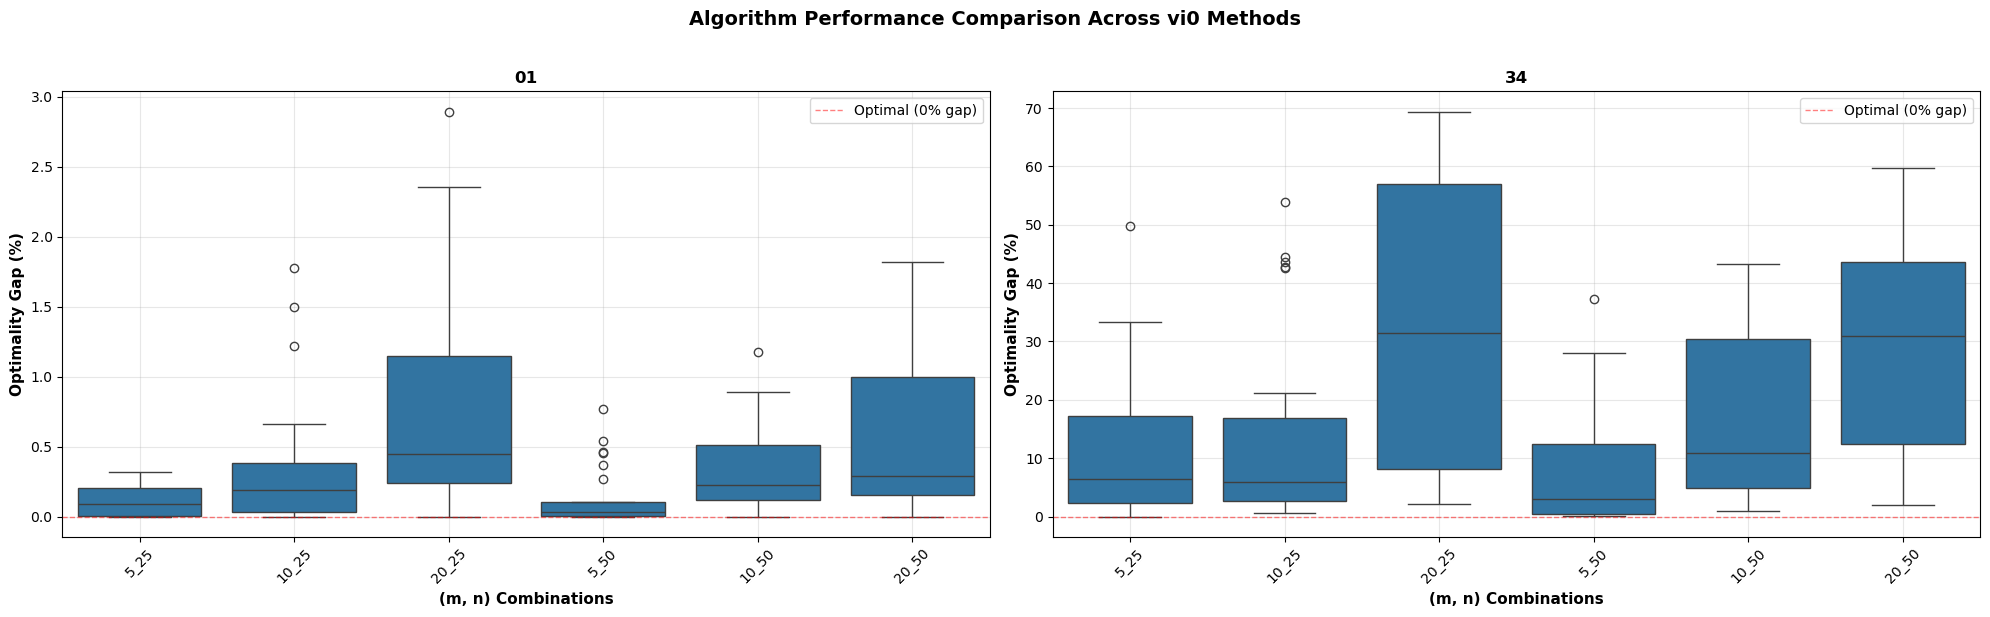


INTERPRETATION GUIDE
• Lower gap values indicate better algorithm performance
• Box shows the interquartile range (25th to 75th percentile)
• Line inside box represents the median
• Whiskers show the full range (excluding outliers)
• Points beyond whiskers are outliers
• uniform01: Low outside-nest utility (easier instances)
• uniform34: High outside-nest utility (harder instances)


In [12]:
# =============================================================================
# PART 5: VISUALIZE ALGORITHM PERFORMANCE
# =============================================================================

# -----------------------------------------------------------------------------
# Visualization 1: Side-by-Side Comparison by vi0 Method
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
vi0_methods = df_results['vi0_method'].unique()

for idx, vi0_method in enumerate(vi0_methods):
    df_vi0 = df_results[df_results['vi0_method'] == vi0_method]
    
    # Create boxplot showing gap distribution for each (m, n) combination
    sns.boxplot(data=df_vi0, x='m_n', y='gap_method', ax=axes[idx])
    
    # Customize plot appearance
    axes[idx].set_xlabel('(m, n) Combinations', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Optimality Gap (%)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{vi0_method}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add reference line at 0% gap (perfect solution)
    axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=1, 
                      label='Optimal (0% gap)')
    axes[idx].legend()

plt.suptitle('Algorithm Performance Comparison Across vi0 Methods', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print interpretation guide
print("\n" + "=" * 80)
print("INTERPRETATION GUIDE")
print("=" * 80)
print("• Lower gap values indicate better algorithm performance")
print("• Box shows the interquartile range (25th to 75th percentile)")
print("• Line inside box represents the median")
print("• Whiskers show the full range (excluding outliers)")
print("• Points beyond whiskers are outliers")
print("• uniform01: Low outside-nest utility (easier instances)")
print("• uniform34: High outside-nest utility (harder instances)")

IndexError: index 2 is out of bounds for axis 0 with size 2

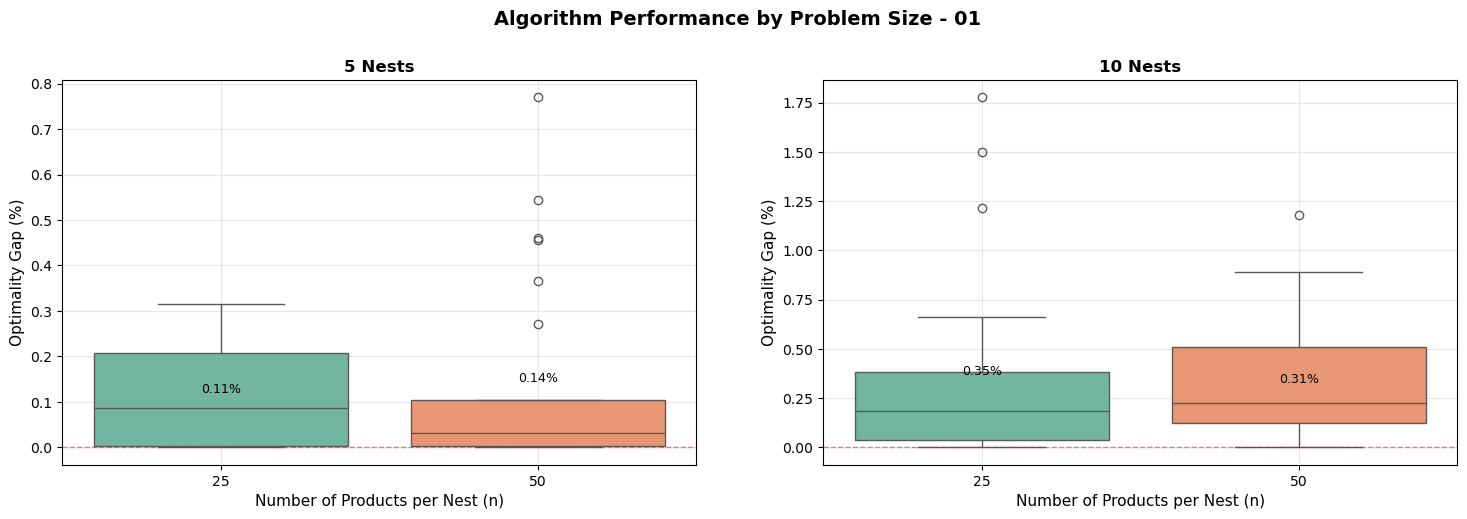

In [13]:
# -----------------------------------------------------------------------------
# Visualization 2: Detailed Analysis by Number of Nests
# -----------------------------------------------------------------------------

# Create separate figures for each vi0 method
for vi0_method in vi0_methods:
    df_vi0 = df_results[df_results['vi0_method'] == vi0_method]
    
    # Create subplots for different values of m (number of nests)
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle(f'Algorithm Performance by Problem Size - {vi0_method}', 
                 fontsize=14, fontweight='bold', y=1.02)
    
    m_values = sorted(df_vi0['m'].unique())
    
    for idx, m_val in enumerate(m_values):
        # Filter data for this specific m value
        df_m = df_vi0[df_vi0['m'] == m_val]
        
        # Create boxplot showing how performance varies with number of products
        sns.boxplot(data=df_m, x='n', y='gap_method', hue='n', 
                    ax=axes[idx], palette='Set2', legend=False)
        
        # Customize subplot
        axes[idx].set_title(f'{m_val} Nests', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Number of Products per Nest (n)', fontsize=11)
        axes[idx].set_ylabel('Optimality Gap (%)', fontsize=11)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=1)
        
        # Add mean value annotation
        means = df_m.groupby('n')['gap_method'].mean()
        for n_val, mean_val in means.items():
            axes[idx].text(list(df_m['n'].unique()).index(n_val), mean_val, 
                          f'{mean_val:.2f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary for this vi0 method
    print(f"\n{vi0_method} Performance Summary:")
    print(df_vi0.groupby(['m', 'n'])['gap_method'].agg(['mean', 'std', 'min', 'max']).round(4))